In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# additional package
from sklearn.utils import shuffle
from sklearn.model_selection import LeavePGroupsOut
# from imblearn.under_sampling import RandomUnderSampler


# random state flow
random_state = 42

In [20]:
data = pd.read_csv(r'C:\Users\Ashley Nguyen\OneDrive - vnu.edu.vn\UET\2019_2020_TB_ERA5_full_11.csv')
print('Dataset: ', str(data.shape)) 
data.head(5)

Dataset:  (637572, 80)


,utc_time,x_id,y_id,value,i4b_value,wvb_value,b09_value,b10_value,b11_value,b12_value,...,ETSS,KINDEX,TCW,TCWV,UWIND_250,UWIND_850,VWIND_250,VWIND_850,DEM,ISOR
0,2020-10-26 12:00:00,130,76,0.0,0.870735,0.883328,0.860329,0.896243,0.870920,0.895987,...,0.576341,0.886203,0.429348,0.595034,0.195173,0.495322,0.511262,0.467618,0.002960,0.424399
1,2020-08-28 20:00:00,130,14,0.0,0.877604,0.888154,0.861931,0.878593,0.826913,0.843483,...,0.571899,0.931145,0.461796,0.640341,0.311098,0.619185,0.462160,0.577644,0.000275,0.105808
2,2019-09-21 11:00:00,93,4,0.0,0.858581,0.935710,0.926165,0.943500,0.845006,0.860251,...,0.530083,0.771234,0.241926,0.335146,0.271965,0.488054,0.405301,0.386573,0.010132,0.464755
3,2019-08-24 08:00:00,122,23,0.0,0.943360,0.902315,0.881433,0.907962,0.908741,0.906498,...,0.567428,0.891413,0.481995,0.666615,0.243112,0.497293,0.489110,0.457800,0.001404,0.418493
4,2019-06-04 13:00:00,109,61,0.0,0.907376,0.881082,0.845513,0.874999,0.870846,0.884279,...,0.572973,0.928003,0.483346,0.670614,0.358321,0.656097,0.463694,0.589375,0.000763,0.475774


In [21]:
# remove unused columns 
data = data.drop(['CIN'], axis=1)

In [22]:
# create classified label column with threshold 0 mm
# True: Rain label, value > 0
# False: Dry label, value = 0

N = data.shape[0] # whole data size
rain = data[data['value'] > 0.2].shape[0] # rain size
dry = data[~ (data['value'] > 0.2)].shape[0] # dry size

print("Number of 'Rain' label:", rain, ' ~ {0:.2f}%'.format(rain / N * 100))
print("Number of 'Dry' label:", dry, ' ~ {0:.2f}%'.format(dry / N * 100))

Number of 'Rain' label: 208503  ~ 32.70%
Number of 'Dry' label: 429069  ~ 67.30%


Under-sampling method

In [23]:
# # Under-sampling method
# rus = RandomUnderSampler(random_state=random_state)

# # Balance data using under-sampling method
# data_res, Y_res = rus.fit_resample(data, data['value'] > 0.2)
# print("Sample size:")
# print("Total:", len(Y_res))
# print("True: ", Y_res.sum())
# print("False:", (~ Y_res).sum())
# data_res.head(3)

In [24]:
# # create classified label column with threshold 0 mm
# # True: Rain label, value > 0
# # False: Dry label, value = 0

# N = data_res.shape[0] # whole data size
# rain = data_res[data_res['value'] > 0.2].shape[0] # rain size
# dry = data_res[~ (data_res['value'] > 0.2)].shape[0] # dry size

# print("Number of 'Rain' label:", rain, ' ~ {0:.2f}%'.format(rain / N * 100))
# print("Number of 'Dry' label:", dry, ' ~ {0:.2f}%'.format(dry / N * 100))

Group data by location (row, col)

number of groups: 339


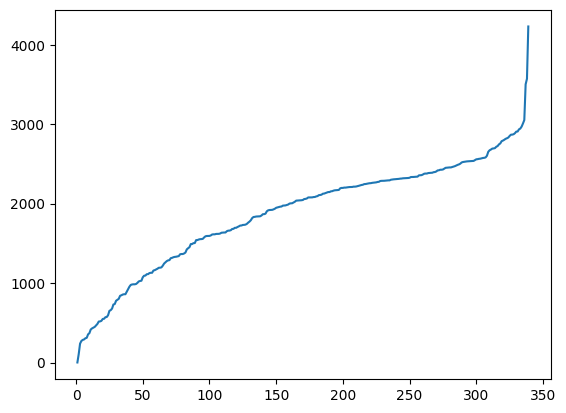

In [25]:
# group data by location (row, col)
grps = data.groupby(['y_id', 'x_id']).size().rename("Count")

# number of station (pixel, group)
print("number of groups:", len(grps))

# plot distribution of each station sample size
plt.plot(
    np.arange(1, len(grps) + 1, 1),
    grps.sort_values(),
)

plt.show()

In [26]:
grps = data.groupby(['y_id', 'x_id'])

# Number of station as test set
n_groups = int(len(grps) * 0.2)

# Stratisfied split method
lpgo = LeavePGroupsOut(
    n_groups = n_groups
)

# index group
ids = np.arange(len(grps)) + 1
ids = shuffle(ids, random_state=random_state)
print(ids)
for i, (idx, grp) in enumerate(grps):
    data.loc[grp.index, 'group'] = ids[i]

# shuffle data then split train/test
train_idx, test_idx = next(lpgo.split(data, groups=data['group']))

data_train = data.iloc[train_idx]
data_test = data.iloc[test_idx]

print("Train size:", len(data_train))

print("Test size: ", len(data_test))

data_test.head(3)

[285 117 114  43 127 232 182 279 337  26 125 222 262 156 110 173 119 326
 267  10 281  56 166 120 145  91 109 211 140 315 177  40 105 317  79   6
 301 330 111  77  85   4 159 229  47 316 287 297  74  34 320 183 204  83
  64 198  58 332 335  46 306 307 318 174 209  73  76  17  67 115   8 138
 329 303 299  78 146 199 255  61 102 273  95 200 148  18  25 276 144 223
 251 269 212 248 153 210  20 195  80 322  19 141 323  32 243 235 164 247
 149 178  60 112 133  16   7 298 220  94  31  23 290 300  57 186  11 230
 240  82 324 203 233 168 221 180  93  70 238  97 286  98 181  69  24  38
 123  68 272 154 126 147 196  87 288 249 289 158 259 169 234 302 257 130
  39 256 239 176 113 275 228 118 319 328 241 308 165 197 224 155 226   3
 116 184 225 121 263 295 128  75  30  84 283 108 194 280 134 185 245  45
 313  66 254  86 187  71 160  13  36  29 171 143 246 132 278  52  96 261
 179 205 124  42  90 266 207 137  27 333 142 284   5   1 305 292 325 101
 227 193 293 219 214 104 172  99  37 216  62 151  4

,utc_time,x_id,y_id,value,i4b_value,wvb_value,b09_value,b10_value,b11_value,b12_value,...,KINDEX,TCW,TCWV,UWIND_250,UWIND_850,VWIND_250,VWIND_850,DEM,ISOR,group
2,2019-09-21 11:00:00,93,4,0.0,0.858581,0.935710,0.926165,0.943500,0.845006,0.860251,...,0.771234,0.241926,0.335146,0.271965,0.488054,0.405301,0.386573,0.010132,0.464755,64.0
25,2020-10-29 19:00:00,110,65,1.4,0.848344,0.910789,0.885994,0.905653,0.841974,0.867746,...,0.934590,0.520076,0.700001,0.226145,0.328678,0.585798,0.588377,0.000824,0.416205,2.0
32,2020-10-13 17:00:00,119,75,0.2,0.773934,0.831109,0.773762,0.796534,0.683481,0.746234,...,0.867517,0.397960,0.550819,0.201389,0.577833,0.370218,0.247215,0.005341,0.545790,59.0


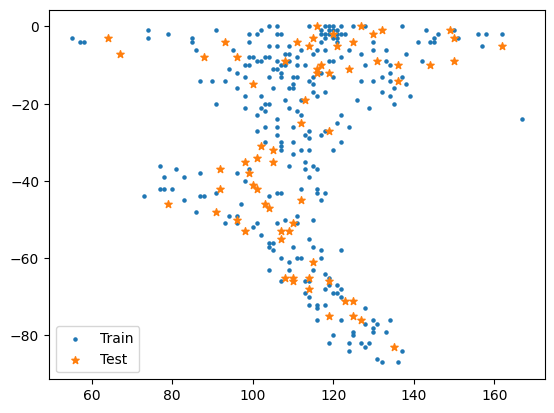

In [27]:
# plot train test location

train_loc = data_train[['y_id', 'x_id']].drop_duplicates()
test_loc = data_test[['y_id', 'x_id']].drop_duplicates()

plt.scatter(
    train_loc['x_id'],
    - train_loc['y_id'],

    marker = '.',
    s = 20,
)

plt.scatter(
    test_loc['x_id'],
    - test_loc['y_id'],

    marker = '*',
    s = 30,
)

plt.legend(['Train', 'Test'])

# png_path = r'/content/drive/MyDrive/INDRA/Calibration/Data/Clf/Tmp/TrainTest_distribution_rs' + str(random_state) + '.png'
# plt.savefig(png_path)
plt.show()

In [28]:
# Save dataset

# export data to pickle
pkl_path = r'C:\Users\Ashley Nguyen\OneDrive - vnu.edu.vn\UET\VIỄN THÁM\PROJECT\RainfallEstimation\data\Train\Clf_Train_rs' + str(random_state) + '.pkl'

data_train.to_pickle(pkl_path)
pkl_path = r'C:\Users\Ashley Nguyen\OneDrive - vnu.edu.vn\UET\VIỄN THÁM\PROJECT\RainfallEstimation\data\Test\Clf_Test_rs' + str(random_state) + '.pkl'
data_test.to_pickle(pkl_path)

# export data to csv
csv_path = r'C:\Users\Ashley Nguyen\OneDrive - vnu.edu.vn\UET\VIỄN THÁM\PROJECT\RainfallEstimation\data\Train/Clf_Train_rs' + str(random_state) + '.csv'
data_train.to_csv(csv_path)
csv_path = r'C:\Users\Ashley Nguyen\OneDrive - vnu.edu.vn\UET\VIỄN THÁM\PROJECT\RainfallEstimation\data\Test/Clf_Test_rs' + str(random_state) + '.csv'
data_test.to_csv(csv_path)